In [1]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time
from sklearn.cluster import KMeans

# SVC, KNeighborsRegressor() 

In [150]:
# Get the summary of property and area characteristics, plus sold price
# However, the property price dataset is likely to include government schemes, shared owernship 
# Therefore exclude any property with very low sold price
# Assume the minimum property price is 200000
# Also filter out anything less than 15sqm or more than 300 as there may be mistake in epc data


engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    p.brn, p.year, p.lsoa, c.ward_name, e.number_habitable_rooms, 
    CASE WHEN p.type in ('S', 'T') THEN 'TS' ELSE p.type END as type, 
    p.duration, p.new, e.construction_age_band, 
    CASE WHEN e.potential_energy_rating in ('A', 'B') THEN 'good' WHEN e.potential_energy_rating in ('C', 'D') THEN 'ok' ELSE 'bad' end as potential_energy_rating , 
    sum_cases, avg_no_of_res, 
    CASE WHEN num_of_stations > 0 THEN 1 ELSE 0 END as num_of_stations, 
    CASE WHEN num_of_stores > 0 THEN 1 ELSE 0 END as num_of_stores, 
    num_of_schools, 
    CASE WHEN num_of_top_schools >0 THEN 1 ELSE 0 END as num_of_top_schools,
    
    ROUND( ((CAST(potential_energy_efficiency as float) - CAST(current_energy_efficiency as float) )/CAST(potential_energy_efficiency as float))::numeric, 1) as diff,
    CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqm_price,
    e.total_floor_area,
    p.price
    
from prices as p
join epc as e
on e.brn = p.brn

join ( select c.year, c.lsoa, g.ward_name, sum(c.value) as sum_cases, avg(g.no_of_res) as avg_no_of_res
from crime_by_year as c
join geo2 as g
on g.lsoa = c.lsoa
where g.no_of_res != 0
group by 1, 2, 3) as c
on p.lsoa = c.lsoa and p.year = c.year

left join (select lsoa, count(station) as num_of_stations
from stations group by 1) as s
on s.lsoa = p.lsoa

left join (select lsoa, count(distinct name) as num_of_stores from stores group by 1) as st
on st.lsoa = p.lsoa


left join (select lsoa, count(distinct school_nam) as num_of_schools from schools2 group by 1) as sc
on sc.lsoa = p.lsoa

left join (select lsoa, count(distinct school_nam) as num_of_top_schools from schools2 where top_rated = 'Y' group by 1) as sc2
on sc2.lsoa = p.lsoa

where e.total_floor_area <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null and e.potential_energy_efficiency <>0
and p.price > 200000
and e.total_floor_area > 15 and e.total_floor_area < 300
and CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) > 1000 and CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) < 16000
and e.number_habitable_rooms < 7
and  p.type != 'O'
;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result = result.fillna(0)
result["diff"] = result["diff"].astype('float')
print(result.shape)
result.head()

(993255, 20)


,brn,year,lsoa,ward_name,number_habitable_rooms,type,duration,new,construction_age_band,potential_energy_rating,sum_cases,avg_no_of_res,num_of_stations,num_of_stores,num_of_schools,num_of_top_schools,diff,sqm_price,total_floor_area,price
0,4.552979e+09,2008.0,E01000006,Abbey,5.0,TS,F,N,1900-1929,good,104.0,1703.0,0,0,14.0,0,0.3,2632,95.00,249995.0
1,3.923376e+09,2009.0,E01000006,Abbey,5.0,TS,F,N,1930-1949,good,91.0,1703.0,0,0,14.0,0,0.3,2165,97.00,210000.0
2,3.923376e+09,2009.0,E01000006,Abbey,5.0,TS,F,N,1900-1929,bad,91.0,1703.0,0,0,14.0,0,0.3,2452,85.64,210000.0
3,7.607591e+09,2009.0,E01000006,Abbey,5.0,TS,F,N,1930-1949,bad,91.0,1703.0,0,0,14.0,0,0.2,2197,94.24,207000.0
4,5.584590e+09,2009.0,E01000006,Abbey,3.0,TS,F,N,1900-1929,ok,91.0,1703.0,0,0,14.0,0,0.1,5000,58.00,290000.0


In [169]:
df = result[result.year > 2017][['lsoa', 'number_habitable_rooms', 'type',
       'duration', 'new', 'construction_age_band', 'potential_energy_rating', 'diff', 'sqm_price',
       'total_floor_area']]

# Encode categorical variables with the mean target value of that category for corresponding lsoa area (as we know that the 
# price of property is highly dependent on the area)
df['type'] = df.groupby(['type', 'lsoa'])['sqm_price'].transform('mean')
df['duration'] = df.groupby(['duration', 'lsoa'])['sqm_price'].transform('mean')
df['new'] = df.groupby(['new', 'lsoa'])['sqm_price'].transform('mean')
df['construction_age_band'] = df.groupby(['construction_age_band', 'lsoa'])['sqm_price'].transform('mean')
df['potential_energy_rating'] = df.groupby(['potential_energy_rating', 'lsoa'])['sqm_price'].transform('mean')
df['lsoa'] = df.groupby(['lsoa'])['sqm_price'].transform('mean')

In [170]:
# Split to features and target
X = df.drop("sqm_price", axis=1)
y = df["sqm_price"]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

regr = RandomForestRegressor(n_estimators = 200, random_state=0)
regr.fit(X_train, y_train)
df_features = pd.DataFrame(np.stack([X.columns.values, regr.feature_importances_], axis=1), columns=["Feature", "Rank"]).sort_values(by="Rank", ascending=False)
train_score = regr.score(X_train, y_train)
test_score = regr.score(X_test, y_test)

predictions_train = pd.DataFrame(regr.predict(X_train)).rename(columns={0: "prediction"})
predictions_train["Actual"] = pd.DataFrame(y_train).reset_index().drop("index", axis=1)

predictions_test = pd.DataFrame(regr.predict(X_test)).rename(columns={0: "prediction"})
predictions_test["Actual"] = pd.DataFrame(y_test).reset_index().drop("index", axis=1)

mse_train = np.sqrt(np.power((predictions_train["Actual"] - predictions_train["prediction"]), 2).sum()/predictions_train.shape[0])
mse_test = np.sqrt(np.power((predictions_test["Actual"] - predictions_test["prediction"]), 2).sum()/predictions_test.shape[0])

print("test ", test_score)
print("train ", train_score)

print("rmse_train ", mse_train)
print("rmse_test ", mse_test)

test  0.7708884106840568
train  0.9626816638156697
rmse_train  460.1766044659221
rmse_test  1145.4609093995932


In [12]:
set([estimator.tree_.max_depth for estimator in regr.estimators_])
# depth of the trees is between 42 and 57 if not max depth set

{42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 57}

In [171]:
# Split to features and target
start = time.time()
X = df.drop("sqm_price", axis=1)
y = df["sqm_price"]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

regr = RandomForestRegressor(n_estimators= 500, min_samples_split= 5, min_samples_leaf= 2, max_features= 'sqrt', max_depth= 40, bootstrap= True, random_state=0)
regr.fit(X_train, y_train)
df_features = pd.DataFrame(np.stack([X.columns.values, regr.feature_importances_], axis=1), columns=["Feature", "Rank"]).sort_values(by="Rank", ascending=False)
train_score = regr.score(X_train, y_train)
test_score = regr.score(X_test, y_test)

predictions_train = pd.DataFrame(regr.predict(X_train)).rename(columns={0: "prediction"})
predictions_train["Actual"] = pd.DataFrame(y_train).reset_index().drop("index", axis=1)

predictions_test = pd.DataFrame(regr.predict(X_test)).rename(columns={0: "prediction"})
predictions_test["Actual"] = pd.DataFrame(y_test).reset_index().drop("index", axis=1)

mse_train = np.sqrt(np.power((predictions_train["Actual"] - predictions_train["prediction"]), 2).sum()/predictions_train.shape[0])
mse_test = np.sqrt(np.power((predictions_test["Actual"] - predictions_test["prediction"]), 2).sum()/predictions_test.shape[0])

running_time = ( time.time() - start)/60

print("test ", test_score)
print("train ", train_score)

print("mse_train ", mse_train)
print("mse_test ", mse_test)
print(running_time)

test  0.7793994132319265
train  0.9191486446519452
mse_train  677.3405111057257
mse_test  1123.9838612895035
3.1808040022850035


In [168]:
df_features

,Feature,Rank
5,construction_age_band,0.293431
2,type,0.19181
3,duration,0.128845
6,potential_energy_rating,0.110954
4,new,0.0796413
10,total_floor_area,0.0735723
0,lsoa,0.0589838
7,sum_cases,0.0214186
8,avg_no_of_res,0.0148764
1,number_habitable_rooms,0.0138345


# Analyze the results

In [153]:
predictions_test["diff"] = predictions_test["Actual"] - predictions_test["prediction"]
predictions_test["diff_perc"] = predictions_test["diff"]/predictions_test["Actual"]

In [154]:
predictions_test.describe()

,prediction,Actual,diff,diff_perc
count,39755.000000,39755.000000,39755.000000,39755.000000
mean,6348.990813,6356.153088,7.162275,-0.027900
std,2067.199329,2393.107490,1125.712877,0.184072
min,2304.947858,1240.000000,-9034.746625,-3.266806
25%,4819.610197,4667.000000,-500.192804,-0.093291
50%,5808.415499,5741.000000,-35.816458,-0.006486
75%,7455.886488,7471.000000,444.448726,0.070768
max,15451.882724,15998.000000,9458.217140,0.697920


In [155]:
# On average our prediction is 2.8% lower than actual
# However most examples are within 20% difference from actual
# With the highest being 60% higher prediction than actual 
# and 650% lower prediction that actual

# let's examine those extreme cases
# but first we get back property characteristics
df = pd.concat( [result[result.year > 2017].loc[X_test.index].reset_index().drop("index", axis=1), predictions_test], axis=1)

In [156]:
predictions_test[(predictions_test.diff_perc < -0.23) | (predictions_test.diff_perc > 0.23) ]

,prediction,Actual,diff,diff_perc
11,9708.596304,13774,4065.403696,0.295151
12,4888.392778,3864,-1024.392778,-0.265112
15,7759.361181,6056,-1703.361181,-0.281268
17,7820.910288,10833,3012.089712,0.278048
24,4380.502576,3008,-1372.502576,-0.456284
...,...,...,...,...
39709,10007.132575,8101,-1906.132575,-0.235296
39714,8148.595562,11212,3063.404438,0.273226
39729,9007.264089,13306,4298.735911,0.323067
39732,8681.822781,12820,4138.177219,0.322791


In [159]:
print(f"{5498/44161} of properties prediction was off by more than 23%")

0.1244989923235434 of properties prediction was off by more than 23%


In [158]:
print(f"{predictions_test[(predictions_test.diff_perc > 0.05) | (predictions_test.diff_perc < -0.05) ].shape[0]/44161} of properties were pedicted within 5% of actual price")

0.6000090577659021 of properties were pedicted within 5% of actual price


In [160]:
# Analyze extreme outliers
df["extreme_diff"] = [1 if x>0.20 else 2 if x < -0.20 else 0 for x in df["diff_perc"] ]

In [161]:
# Year
# Check if any specific year brings proportionally higher difference than the other year
temp = pd.pivot_table(index="year",columns="extreme_diff", values="brn", data=df.groupby(["year", "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/temp[0]
temp["overvalued"] = temp[2]/temp[0]
temp

# The % of properties over/under estimated is consitently 14% each year

extreme_diff,year,0,1,2,undervalued,overvalued
0,2018.0,13199,835,1651,0.063262,0.125085
1,2019.0,13187,758,1937,0.057481,0.146887
2,2020.0,6860,531,797,0.077405,0.116181


In [162]:
# Bedrooms
col = "number_habitable_rooms"
temp = pd.pivot_table(index=col,columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/temp[0]
temp["overvalued"] = temp[2]/temp[0]
temp

# The % of properties over/under estimated is consitently between 12-17% and jumpts to 32% for property with 8 or more bedroom
# Potentially remove those outliers from the dataset
# Most properties in London have less than 8 bedrooms


extreme_diff,number_habitable_rooms,0,1,2,undervalued,overvalued
0,1.0,283,20,37,0.070671,0.130742
1,2.0,3958,268,551,0.067711,0.139212
2,3.0,9858,637,1287,0.064618,0.130554
3,4.0,8047,483,1063,0.060022,0.132099
4,5.0,7640,470,948,0.061518,0.124084
5,6.0,3460,246,499,0.071098,0.144220


In [163]:
# Type
col = "type"
temp = pd.pivot_table(index=col,columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/(temp[0] + temp[2])
temp["overvalued"] = temp[2]/(temp[0] + temp[1])
temp

# F (flats) 17% of predictions are outside 23% difference The highest is for O (Other) which could be garrage etc - overvalued
# The best is to exclude those from the dataset

# Combine  S+T, so have only D, F, T

extreme_diff,type,0,1,2,undervalued,overvalued
0,D,1073,150,109,0.126904,0.089125
1,F,14651,887,2529,0.051630,0.162762
2,TS,17522,1087,1747,0.056412,0.093879


In [164]:
# Duration
col = "duration"
temp = pd.pivot_table(index=col,columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/(temp[0] + temp[2])
temp["overvalued"] = temp[2]/(temp[0] + temp[1])
temp

# 17% of Leaseholds are incorrectly overvalued
# Possibly due to less leasholds and leasholds in general being slightly cheaper than Freeholds

# Resample leases to make dataset more balanced

extreme_diff,duration,0,1,2,undervalued,overvalued
0,F,18230,1214,1773,0.060691,0.091185
1,L,15016,910,2612,0.051622,0.164009


In [165]:
# New
col = "new"
temp = pd.pivot_table(index=col,columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/(temp[0] + temp[2])
temp["overvalued"] = temp[2]/(temp[0] + temp[1])
temp

# 20% of new build are incorrectly estimated
# 

extreme_diff,new,0,1,2,undervalued,overvalued
0,N,33187,2120,4382,0.056430,0.124111
1,Y,59,4,3,0.064516,0.047619


In [136]:
# construction_age_band
col = "construction_age_band"
temp = pd.pivot_table(index=col,columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/(temp[0] + temp[2])
temp["overvalued"] = temp[2]/(temp[0] + temp[1])
temp

# 20% of Before 1929 are incorrectly estimated

# Cluster into less buckets

extreme_diff,construction_age_band,0,1,2,undervalued,overvalued
0,0,322,9,18,0.026471,0.054381
1,1900-1929,8543,866,1512,0.086126,0.160697
2,1930-1949,9906,571,1136,0.051712,0.108428
3,1950-1966,4498,175,500,0.035014,0.106998
4,1967-1975,2701,77,278,0.025848,0.100072
5,1976-1982,1161,29,122,0.022603,0.102521
6,1983-1990,1493,52,170,0.031269,0.110032
7,1991-1995,814,16,65,0.018203,0.078313
8,1996-2002,1285,59,119,0.042023,0.088542
9,2003-2006,1059,52,70,0.046058,0.063006


In [137]:
# potential_energy_rating
col = "potential_energy_rating"
temp = pd.pivot_table(index=col,columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/(temp[0] + temp[2])
temp["overvalued"] = temp[2]/(temp[0] + temp[1])
temp

# Overvalue properties with C, D, E rating

# Group A+B into GOOD
# C+D into Potential
# E, F, G = bad

extreme_diff,potential_energy_rating,0,1,2,undervalued,overvalued
0,A,155,3,8,0.018405,0.050633
1,B,15008,770,1534,0.046548,0.097224
2,C,16533,1122,2491,0.058978,0.141093
3,D,4232,405,723,0.081736,0.155920
4,E,764,79,105,0.090909,0.124555
5,F,153,6,12,0.036364,0.075472
6,G,50,1,7,0.017544,0.137255


In [138]:
# Top areas with prediction less than actual
col = "ward_name"
temp = pd.pivot_table(index=col,columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/temp[0]
temp["overvalued"] = temp[2]/temp[0]
temp = temp.sort_values(by="undervalued", ascending=False)
temp.head(10)

# Most of the areas are central and expensive
# potentially the price in those areas varies a lot due to property condition etc

extreme_diff,ward_name,0,1,2,undervalued,overvalued
252,Knightsbridge and Belgravia,11.0,6.0,4.0,0.545455,0.363636
277,Marylebone High Street,17.0,5.0,4.0,0.294118,0.235294
184,Hampstead Town,35.0,9.0,5.0,0.257143,0.142857
375,St. Leonard's,51.0,13.0,17.0,0.254902,0.333333
14,Bayswater,40.0,10.0,14.0,0.250000,0.350000
274,Mapesbury,33.0,8.0,13.0,0.242424,0.393939
11,Barnes,50.0,12.0,7.0,0.240000,0.140000
254,Ladywell,52.0,12.0,8.0,0.230769,0.153846
47,Bryanston and Dorset Square,40.0,9.0,10.0,0.225000,0.250000
37,Brentford,47.0,10.0,9.0,0.212766,0.191489


In [132]:
# Top areas with prediction less than actual
col = "ward_name"
temp = pd.pivot_table(index=col,columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/temp[0]
temp["overvalued"] = temp[2]/temp[0]
temp = temp.sort_values(by="overvalued", ascending=False)
temp.tail(10)


extreme_diff,ward_name,0,1,2,undervalued,overvalued
320,Pinkwell,43.0,NaN,1.0,NaN,0.023256
347,Royal Docks,46.0,2.0,1.0,0.043478,0.021739
335,Rainham and Wennington,97.0,3.0,2.0,0.030928,0.020619
329,Preston,54.0,3.0,1.0,0.055556,0.018519
73,Chessington North and Hook,58.0,1.0,1.0,0.017241,0.017241
2,Abbey Wood,65.0,2.0,1.0,0.030769,0.015385
206,Heath,71.0,NaN,1.0,NaN,0.014085
129,Elm Park,99.0,1.0,1.0,0.010101,0.010101
18,Beddington South,50.0,2.0,NaN,0.040000,NaN
233,Hounslow West,25.0,NaN,NaN,NaN,NaN


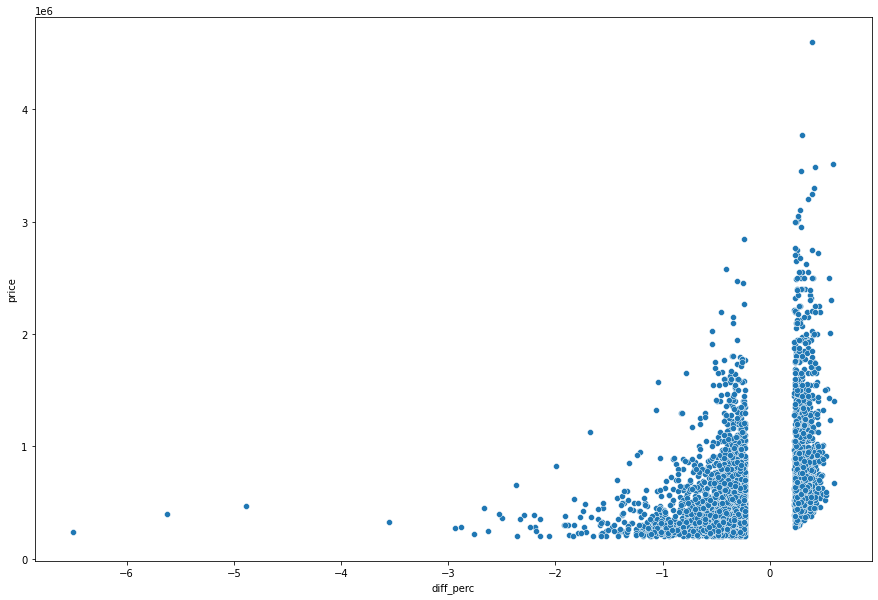

In [105]:
# Price and diff
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df[df.extreme_diff == 1], x="diff_perc", y="price")
plt.show()
# Lower value properties are over estimated

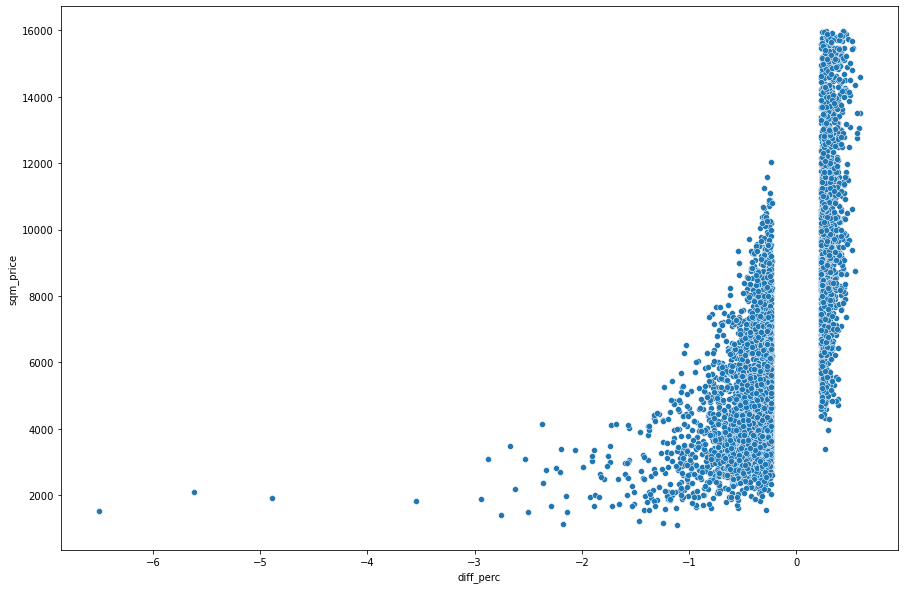

In [108]:
# sqm and diff
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df[df.extreme_diff == 1], x="diff_perc", y="sqm_price")
plt.show()
# Lower value properties are over estimated

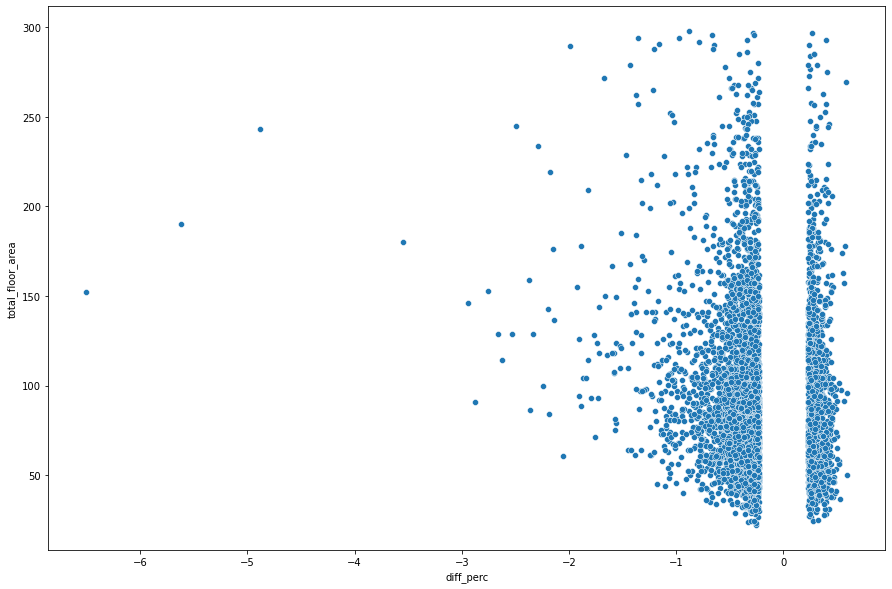

In [109]:
# sqm p and diff
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df[df.extreme_diff == 1], x="diff_perc", y="total_floor_area")
plt.show()
# Lower value properties are over estimated across any property size

In [121]:
# For which properties price is predicted to be lower than actual
# diff perc > 0.2
df["extreme_diff"] = [1 if x>0.20 else 2 if x < -0.20 else 0 for x in df["diff_perc"] ]

In [123]:
col = "new"
temp = pd.pivot_table(index=col, columns="extreme_diff", values="brn", data=df.groupby([col, "extreme_diff"], as_index=False).count()).reset_index()
temp["undervalued"] = temp[1]/temp[0]
temp["overvalued"] = temp[2]/temp[0]
temp

extreme_diff,new,0,1,2,undervalued,overvalued
0,N,36840,2379,4875,0.064577,0.132329
1,Y,55,7,5,0.127273,0.090909


In [110]:
df[df.columns[:]].head(2)

,brn,year,lsoa,ward_name,number_habitable_rooms,type,duration,new,construction_age_band,potential_energy_rating,...,diff,sqm_price,total_floor_area,price,prediction,Actual,diff,diff,diff_perc,extreme_diff
0,8.607379e+09,2019.0,E01033730,Greenwich West,2.0,F,L,N,2003-2006,C,...,993.591709,8095,42.00,340000.0,7101.408291,8095,0.0,993.591709,0.122741,0
1,6.288945e+09,2018.0,E01003958,Southwark,4.0,T,F,N,1900-1929,E,...,335.385641,8351,89.81,750000.0,8015.614359,8351,0.3,335.385641,0.040161,0
